<a href="https://colab.research.google.com/github/chiaralazzeri/GW-analysis/blob/master/Using_RNNs_for_GW_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Recurrent Neural Networks for gravitational waves detection  

The aim of this project was to construct a recurrent neural network (RNN) to analyse waveforms and they contain a gravitational wave signal or just noise.

In [ ]:
# import the necessary packages

!pip3 install torch torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.utils.data import TensorDataset, DataLoader

import os
import h5py 
import numpy as np
import seaborn as sns # for confusion matrix
sns.set()
from sklearn import metrics # for ROC curve and confusion matrix
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def fetch_data(url, filename):   # define function to fetch the data from a give url.
    """Fetch data from a url and save it to given file"""
    import urllib
    urllib.request.urlretrieve(url, filename=filename)

# url of the data
data_url = 'http://www.astro.gla.ac.uk/users/michael/datasets/new_bbh/BBH_data_1s_1024Hz_100Ksamp_1n_H1_astro_2z_8min_SNRuniform_8_8.h5' # training and validation data
data_url_test = 'http://www.astro.gla.ac.uk/users/michael/datasets/new_bbh/without_noise/BBH_data_1s_1024Hz_20Ksamp_1n_H1_astro_2z_8min_SNRuniform_8_8.h5' # testing data


# path to save the data
data_file = './data.h5'

# only download the data if the file doesn't already exist
if not os.path.isfile(data_file):
  fetch_data(data_url, data_file)

data_file_test = './data_test.h5'
if not os.path.isfile(data_file_test):
  fetch_data(data_url_test, data_file_test)

The imported data has shape [100000,1,1024] i.e. [number of waveforms, number of detectors, ] . It has to be reshaped into a tensor of the form [number of waveforms, number of detectors, number of time steps, number of inputs]. For now we'll use [100000,1,1024,1]. Each waveform has an associated label, 0 or 1, which correspond to noise and noise + signal.

In [ ]:
# define function to load the training and loading data:

def load_data(data_file):
    """Load the data and remove the first and last 0.5 seconds of padding"""
    # load the hdf5 datafile
    dataset = h5py.File(data_file, 'r')
    print(f'Dataset keys: {list(dataset.keys())}')    
    x = dataset.file['time_series'][:]
    y = dataset.file['labels'][:]

    #turn data arrays into tensors
    dataT = torch.from_numpy(x)
    y = torch.from_numpy(y)
    print(f'x shape: {dataT.shape}, y shape: {y.shape}')

    # here a dimension is added (for inputs) by reshaping the tensor
    data = torch.reshape(dataT,(100000,1,1024,1))

    return data, y

# a different function is used to load the testing data, as it also contains the noiseless signals

def load_data_test(data_file_test):
    """Load the data and remove the first and last 0.5 seconds of padding""" # we only want one second of data
    # load the hdf5 datafile
    dataset = h5py.File(data_file_test, 'r')
    print(f'Dataset keys: {list(dataset.keys())}')    
    x = dataset.file['time_series'][:]  # waveform of signal + noise
    y = dataset.file['labels'][:]  
    z = dataset.file['time_series_zero_noise'][:] # just signal, no noise

    #turn data arrays into tensors
    dataT = torch.from_numpy(x)
    y = torch.from_numpy(y)
    dataT_0 = torch.from_numpy(z)
    print(f'x shape: {dataT.shape}, y shape: {y.shape}, z shape: {dataT_0.shape}')

    # here a dimension is added (for inputs) by reshaping the tensor
    data = torch.reshape(dataT,(20000,1,1024,1))
    data_0 = torch.reshape(dataT_0,(20000,1,1024,1))

    # load parameters
    print(f"Parameters in the dataset: {list(dataset['parameters'].keys())}")
    m1 = dataset.file['parameters/m1'][:]
    m2 = dataset.file['parameters/m2'][:]
    mc = dataset.file['parameters/mc'][:]

    return data, y, data_0

In [ ]:
data, labels = load_data(data_file) 

Dataset keys: ['labels', 'parameters', 'time_series']
x shape: torch.Size([100000, 1, 1024]), y shape: torch.Size([100000])


In [ ]:
data_test, labels_test, data0_test = load_data_test(data_file_test)

Dataset keys: ['labels', 'parameters', 'time_series', 'time_series_zero_noise']
x shape: torch.Size([20000, 1, 1024]), y shape: torch.Size([20000]), z shape: torch.Size([20000, 1, 1024])
Parameters in the dataset: ['M', 'cosiota', 'dL', 'dec', 'dsnr', 'eta', 'fmin', 'idx', 'iota', 'm1', 'm2', 'mc', 'nsnr', 'phi', 'psi', 'ra', 'z']


I chose to split each waveform is 32 blocks of 32 inputs each. Hence the network will have 32 timesteps and n_inputs = 32. 32x32 seems to be the optimal shape for analysing the data. Each waveform split this way can be imagined to be like an image with n_timesteps rows of pixels and n_inputs columns.

In [ ]:
N_STEPS = 64
N_INPUTS = 16
DATA = torch.reshape(data,(100000,1,N_STEPS,N_INPUTS))
data_test = torch.reshape(data_test, (20000,1,N_STEPS,N_INPUTS) )
data0_test = torch.reshape(data0_test, (20000,1,N_STEPS,N_INPUTS) )
print(DATA.shape, data_test.shape)

torch.Size([100000, 1, 64, 16]) torch.Size([20000, 1, 64, 16])


In [ ]:
# The data from the first data file is split into a training and a validation set, and the same is done for the corresponding labels

data_train, data_val= torch.split(DATA,(90000,10000),dim=0)
labels_train,labels_val = torch.split(labels,(90000,10000),dim=0)
print(data_train.shape, labels_val.shape)

torch.Size([90000, 1, 64, 16]) torch.Size([10000])


The inital data and the reshaped data can be plotted to see whether the reshaping was done correctly.

torch.Size([16, 1])


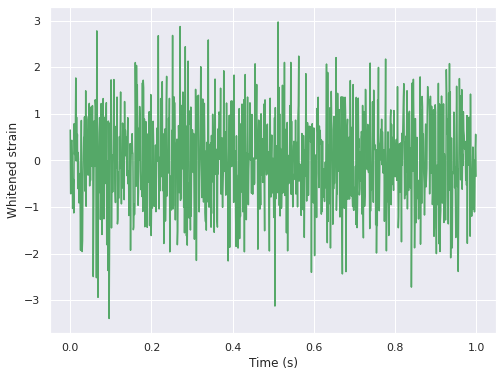

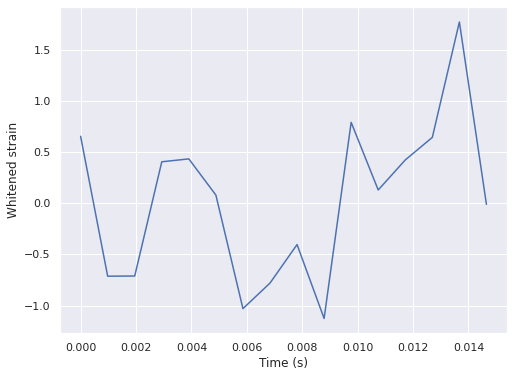

In [ ]:
# PLOT ONE TIME SERIES

fs = 1024                           # sampling frequency
duration = 1
t = np.arange(0, duration, 1. / fs) # array of time steps = 1/fs
plt.figure(figsize=(8,6))
plt.plot(t, data[0,0,0:1024],color='g')
print(data[0,0,0:N_INPUTS].shape)
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")

plt.show()

t2 = np.arange(0, duration/N_STEPS, 1. / fs)  # divided by 16 because there are 16 inputs in our time step
plt.figure(figsize=(8,6))
plt.plot(t2, data_train[0,0,0])
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")

plt.show()

# plot data[0,0,0:N_INPUTS] & DATA[0,0,0] and observe that the graphs are the same i.e. the data has been split correctly

The data is put into three Tensor Datasets for training, validation and testing.

In [ ]:
trainset = TensorDataset(data_train,labels_train)
testset = TensorDataset(data_test, labels_test, data0_test)
valset = TensorDataset(data_val,labels_val)

BATCH_SIZE = 100

my_trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
my_testloader = DataLoader(testset, batch_size = BATCH_SIZE, shuffle = False)
my_validationloader = DataLoader(valset, batch_size= data_val.size(0), shuffle = True)

The network developed during the project was modelled on a recurrent neural network used for image classification that could identify handwritten numbers in a picture (it can be found at https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79).
My data consisted in 1s long waveforms with SNR8. These waveforms were either made up of signal + noise or just noise.
In the image recognition network a single row of pixels was fed into the network at each time step. To mirror this,  So I split each waveform into blocks, as the image was split into rows.
The waveforms, which were 1s long and had sampling frequency 1024 Hz, were split into 32 blocks: so what I had was 32 blocks, each containing 32 inputs, that were fed into the network  at different timesteps.


In [ ]:
# parameters 

N_NEURONS = 32  
N_NEURONS_D = 16
N_OUTPUTS = 2 # two numbers (that summed should give 1) are given as output  
N_EPHOCS = 5 # how many times should we let the network see the data during training
N_LAYERS = 4 # how many stacked LSTMs we want

In [ ]:
class gwLSTM(nn.Module):
  #declare a few variables with initialisation function:
    def __init__(self, batch_size, n_inputs, n_neurons, n_outputs, num_layers, n_neurons_d):  #here
        super(gwLSTM, self).__init__()
        
        self.batch_size = batch_size
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.n_outputs = n_outputs
        self.num_layers = num_layers
        self.n_neurons_d = n_neurons_d

        # declare LSTM layer
        self.lstm = nn.LSTM(self.n_inputs, self.n_neurons, self.num_layers, dropout= 0)
        # declare dense layer
        self.rnn= nn.RNN(self.n_neurons, self.n_neurons_d)
        # declare fully-connected layer 
        self.FC = nn.Linear(self.n_neurons_d, self.n_outputs) #nn.linear Applies a linear transformation to the incoming data
       
    def init_hidden(self,): # returns initial hidden and cell states with zero values
        return (torch.zeros(self.num_layers, self.batch_size, self.n_neurons),
                torch.zeros(self.num_layers, self.batch_size, self.n_neurons))
        
    def init_hidden_d(self,): # returns initial hidden and cell states with zero values
        return (torch.zeros(1, self.batch_size, self.n_neurons_d))
        
    def forward(self, X): # X is our input data
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        self.batch_size = X.size(1) # size of 2nd element of X
        self.hidden = self.init_hidden()
        self.hidden_d = self.init_hidden_d()
        lstm_out, self.hidden = self.lstm(X, self.hidden)    

        if self.training == False:
          OUT = []
          for i in range(0, X.size(0)):
           o, h = self.rnn(lstm_out, self.hidden_d)
           out = self.FC(o[i]) 
           out = out.view(-1, self.n_outputs)
           out = torch.sigmoid(out)
           OUT.append(out)
          return  OUT  # batch_size X n_output
        else:
          o, h = self.rnn(lstm_out, self.hidden_d)
          out = self.FC(o[-1]) 
          out = out.view(-1, self.n_outputs)   # batch_size X n_output
          out = torch.sigmoid(out)
          return  out

In [ ]:
#TEST MODEL

dataiter = iter(my_trainloader)
wave, labels = dataiter.next()
#print(data.shape)
model = gwLSTM(BATCH_SIZE, N_INPUTS, N_NEURONS, N_OUTPUTS, N_LAYERS, N_NEURONS_D)
logits = model(wave.view(-1, N_STEPS,N_INPUTS).float()) # log probabilities of the model.

#print(logits,torch.max(logits,1))#, torch.max(logits,1)[1])
#corrects = (torch.max(logits, 1)[1].view(labels.size()).data == labels.data).sum()
#print(corrects)

print(f'len(logits): {len(logits)}, logits[0].shape: {logits[0].shape}') # should be N_STEPS and batch size x n_outputs

len(logits): 100, logits[0].shape: torch.Size([2])


Logits gives an error if model() is not given a .float() input. Logits has shape (n_batches * n_outputs) just like in the original code.

In [ ]:
# DECLARE HELPER FUNCTIONS TO TEST THE MODEL

import torch.optim as optim

# Before training a model in PyTorch, you can programatically specify what device
# you want to use during training; the torch.device function tells the program
# that we want to use the GPU if one is available, otherwise the CPU will be the default.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance: create an instance of the model, gwLSTM(), with the proper parameters.
model = gwLSTM(BATCH_SIZE, N_INPUTS, N_NEURONS, N_OUTPUTS, N_LAYERS, N_NEURONS_D)   

# it computes the loss of the model
# Applies a log softmax followed by a negative log likelihood loss operation over the output of the model. 
# To compute the loss, the function needs both the log probabilities and targets (labels). 
criterion = nn.CrossEntropyLoss() 

# Need an optimization algorithm which helps to update weights based on the current loss.
# Requires the model parameters and a learning rate. Alternatively, you can also use optim.SGD

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
print(model.parameters)

# The get_accuracy function computes the accuracy of the model given the log probabilities and target values.
def get_accuracy(logit, target, batch_size):
    # Obtain accuracy for training round 
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum() 

# logit is the output array. it has dimensions 50x2. for each of the 50 waveforms in the batch torch.max(input, dim) finds maximum between the 2 numbers.
# torch.max(input, dim)[1] gives the index of the maximum i.e. 0 for noise 1 for signal.
# corrects counts the number of times the result matches the target (min = 0, max = 50)

    accuracy = 100.0 * corrects.item()/batch_size
    return accuracy

<bound method Module.parameters of gwLSTM(
  (lstm): LSTM(16, 32, num_layers=4)
  (rnn): RNN(32, 16)
  (FC): Linear(in_features=16, out_features=2, bias=True)
)>


## STACKING LSTMs

I initially worked with basic rnn cells (nn.RNN) but then I decided to make my network more complex by using LSTM cells. An LSTM cell has an additional long-term memory component that allows it to work better with long strings of data. As the input goes into the cell at each timestep, the hidden state (which is the short term memory component) and the cell state (the long term memory component) both go into the cell. Inside it, three gates help regulate the information that goes into the cell state.

When I started testing the network on concatenated waveforms (see later) the network struggled to confidently detect the signals as the sequence of data it was analysing was much longer and it was probably forgetting what is has seen earlier. So I tried stacking more LSTMs to help improve the memory of the network. An LSTM layer gives the following layer a sequence output: one output per input time step. Initially, when more than 2 LSTMs were stacked the network stopped learning. I had to decrease the learning rate of the network from $ 1 \cdot 10^{-4}$ to $ 5 \cdot 10^{-5}$. The learning rate controls the rate at which the model learns: a smaller learning rate allowed the model to learn a more optimal set of weights but made the training session much longer. This allowed to stack 4 or 5 LSTMs.


## TRAINING THE MODEL

The RNN can now be trained with the training data. After each epoch of training the validation data goes through the network. Both the training and validation loss and accuracy values are returned. These values should be approximately the same. 

Initially the training accuracy reached much higher values than the validation accuracy, which means that the network was overfitting. At the time I was training the network with 8k waveforms. To solve the overfitting problem I made the network (which was made up of a couple of basic RNN cells) more simple, so that it wouldn’t be able to memorise the waveforms, and I increased the number of training waveforms to 80k. 
At this point the network could detect signals with accuracy between 85-90%.


In [ ]:
# loop over the dataset multiple times
# Epochs: number of times the network will train on the complete dataset.
LOSS = []
ACCURACY = []
VAL_ACCURACY = []
VAL_LOSS = []
for epoch in range(N_EPHOCS):  
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(my_trainloader): # restarts the trainloader iterator on each epoch. That is how python iterators work. 
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, N_STEPS, N_INPUTS).float() # this reshapes the input tensor to width & lenght 28

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels) 
        loss.backward() # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. 
        optimizer.step() # optimizer.step updates the value of x using the gradient x.grad.

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
            
    model.eval() # switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.
    LOSS.append(train_running_loss/i)
    ACCURACY.append(train_acc/i)   

    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i)) 

#VALIDATION DATASET
    val_loss = 0
    val_acc = 0.0
    for i, data in enumerate(my_validationloader):
       with torch.no_grad(): 
        inputs, labels = data
        inputs = inputs.view(-1, N_STEPS, N_INPUTS).float() 

        val_outputs = model(inputs)

        loss_v = criterion(val_outputs[-1], labels)
        val_loss += loss_v.detach().item()
        val_acc += get_accuracy(val_outputs[-1], labels, data_val.size(0))


    VAL_ACCURACY.append(val_acc)   
    VAL_LOSS.append(val_loss)  
    print(' Validation Loss: %.4f | Validation Accuracy: %.2f' 
          %(val_loss, val_acc)) 

Epoch:  0 | Loss: 0.6939 | Train Accuracy: 50.04
 Validation Loss: 0.6931 | Validation Accuracy: 50.00
Epoch:  1 | Loss: 0.6939 | Train Accuracy: 50.25
 Validation Loss: 0.6931 | Validation Accuracy: 50.00
Epoch:  2 | Loss: 0.6279 | Train Accuracy: 65.50
 Validation Loss: 0.5136 | Validation Accuracy: 82.73
Epoch:  3 | Loss: 0.4917 | Train Accuracy: 84.10
 Validation Loss: 0.4687 | Validation Accuracy: 85.84
Epoch:  4 | Loss: 0.4631 | Train Accuracy: 86.11
 Validation Loss: 0.4559 | Validation Accuracy: 86.41


## TRAINING VS. VALIDATION  
The validation and training loss and accuracy values should be close.
Initially, when the training was done on 9k waveforms, the validation accuracy was much lower than training accuracy, which means that the network was overfitting. This happens when the network memorises the training waveforms instead of learning. This can be prevented by making the network less complex (adding dropout or decreasing the number of layers) or using more data. Using 90k training waveforms solved the overfitting problem.

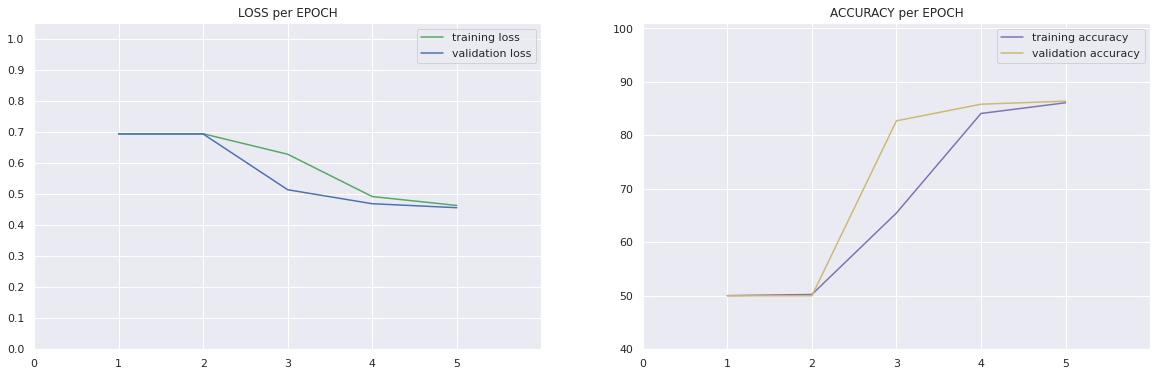

In [ ]:
# Plot validation Loss/Accuracy against training Loss/Accuracy
epochs = np.arange(1, N_EPHOCS + 1)
plt.figure(figsize=[20,6])
plt.subplot(1,2,1)
plt.title('LOSS per EPOCH')
plt.xticks(range(0, N_EPHOCS+1))
plt.yticks(np.arange(0,N_EPHOCS,0.1))
plt.xlim(0, N_EPHOCS+1)
plt.ylim(0, 1.05)
plt.plot(epochs,LOSS,color= 'g', label= 'training loss')
plt.plot(epochs,VAL_LOSS, color='b', label= 'validation loss')
plt.legend()

plt.subplot(1,2,2)
plt.title('ACCURACY per EPOCH')
plt.xticks(range(0, N_EPHOCS+1))
plt.yticks(np.arange(0,105,10))
plt.xlim(0, N_EPHOCS+1)
plt.ylim(40, 101)
plt.plot(epochs,ACCURACY, color='m',label= 'training accuracy')
plt.plot(epochs,VAL_ACCURACY, color='y', label= 'validation accuracy')
plt.legend()
plt.show()

##TESTING  
During the testing the network analyses data it hasn't seen before.

In [ ]:
# compute accuracy on the testing dataset to test how well the model performs. (20 BATCHES)

test_acc = 0.0

P_n = [] # probability of just noise for all batches at all timesteps
P_s = [] # probability of detection for all batches at all timesteps
labels_t = []  # labels for every waveform (10000 labels)
inputs_test = [] # test waveforms
inputs0_test = [] # test waveforms with no signal

for i, data in enumerate(my_testloader,0):
    
    inputsT, labelsT, inputs0T = data
    inputsT = inputsT.view(-1, N_STEPS, N_INPUTS).float()

    outputs = model(inputsT)
    test_acc += get_accuracy(outputs[-1], labelsT, BATCH_SIZE)
    
    p_n = []  # noise prob for ith batch at all time steps
    p_s = []
    for j in range(0,N_STEPS):
      pn = []  # noise prob for ith batch and jth time step
      ps = []
      for k in range(0, BATCH_SIZE):
        outputs[j] = outputs[j].detach()  # so that grad <backwards> isn't printed
        n = outputs[j][k][0].item() # gets noise probability
        s = outputs[j][k][1].item() # gets signal probability
        pn.append(n)  
        ps.append(s)   
      p_n.append(pn)
      p_s.append(ps)
    P_n.append(p_n)
    P_s.append(p_s) 
    labels_t.append(labelsT.tolist()) 
    inputs_test.append(inputsT)
    inputs0_test.append(inputs0T.view(-1, N_STEPS, N_INPUTS))
print('Test Accuracy: %.2f' %(test_acc/(data_test.size(0)/BATCH_SIZE)))  #average test accuracy (num. correct guesses/number of batches)


print(len(P_s), len(P_s[0]),len(P_s[0][0]))
print(len(labels_t), len(labels_t[0]))
print(len(inputs_test),len(inputs_test[0]))
#P_s should have length (n_waveforms/batchsize) and each of its elements (a batch) should have length 32 (timesteps) and each timestep should have 50 elements (batch size)

Test Accuracy: 86.44
200 64 100
200 100
200 100


In [ ]:
# divide all signals and noise inputs into different arrays so that they're more easily plotted

noise = []  
signals = []
signals0 = []
stat_n = []
stat_s = []
noise0 = []

for i in range(0, data_test.size(0)//BATCH_SIZE,1):
  l = labels_t[i]
  for j in range(0,BATCH_SIZE,1):
    if l[j] == 1: # if waveform is a signal
      signals.append(inputs_test[i][j])  # add stats at each time step to signal list
      signals0.append(inputs0_test[i][j])
      s_s = []
      for k in range(0,N_STEPS,1):
        s_s.append(P_s[i][k][j])
      stat_s.append(s_s)
    if l[j] == 0:
      noise.append(inputs_test[i][j])
      noise0.append(inputs0_test[i][j])
      s_n = []
      for k in range(0,N_STEPS,1):
        s_n.append(P_s[i][k][j])
      stat_n.append(s_n)

print(len(noise0),len(signals0))

10000 10000


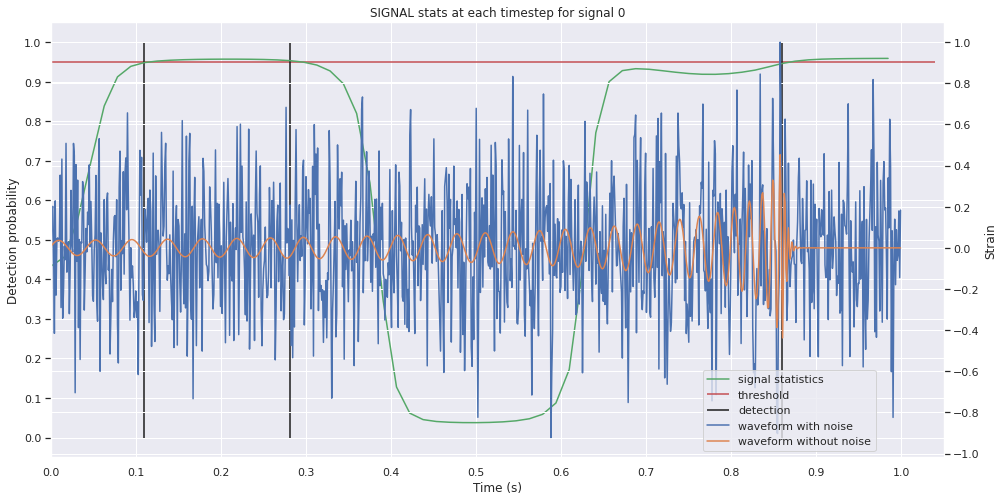

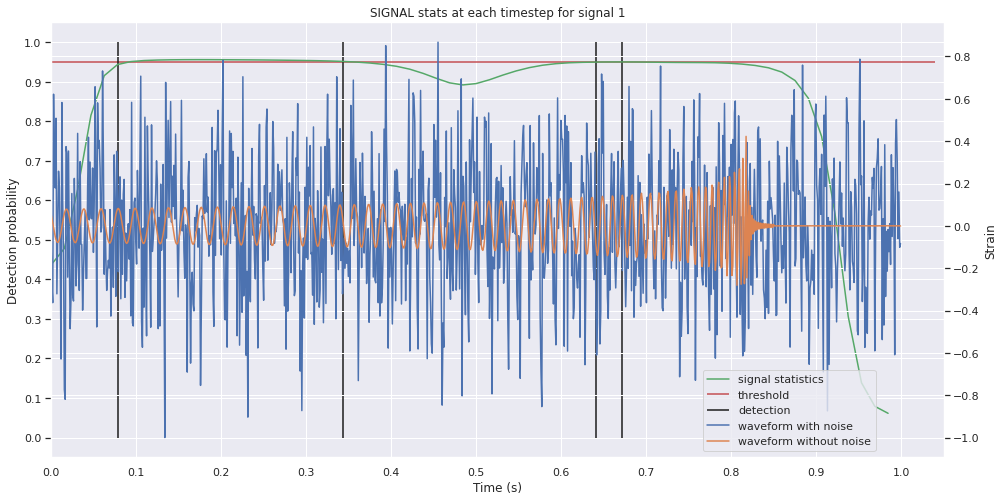

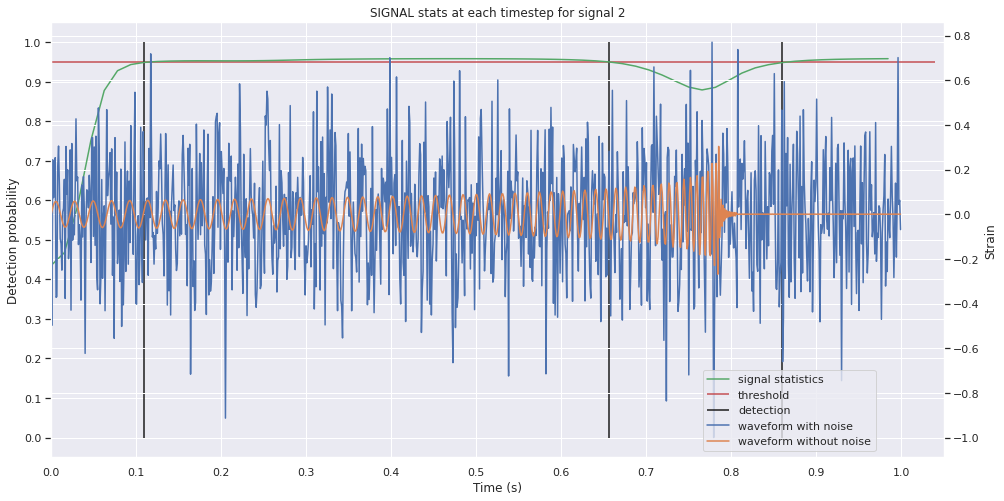

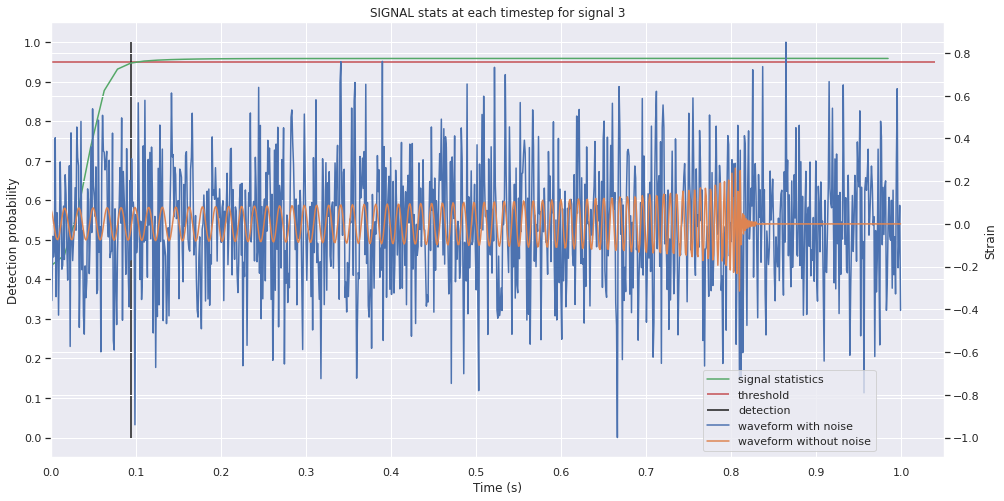

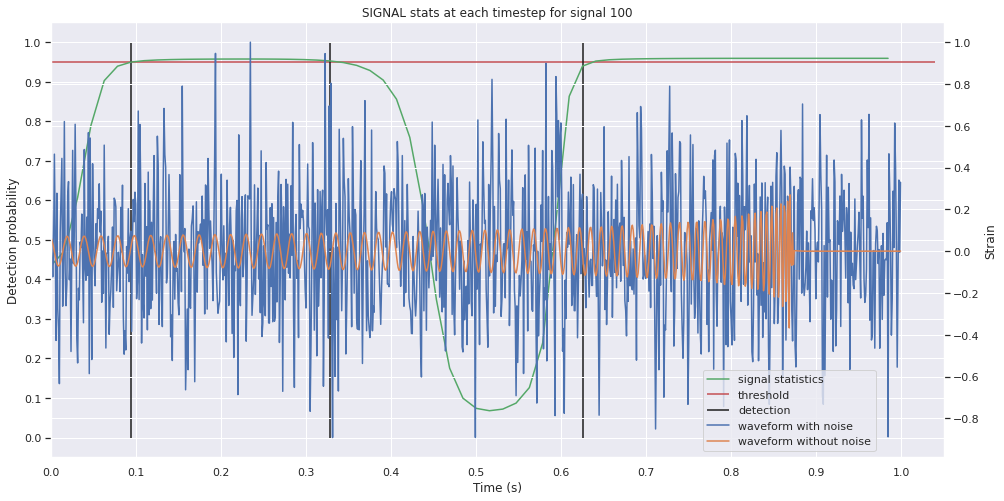

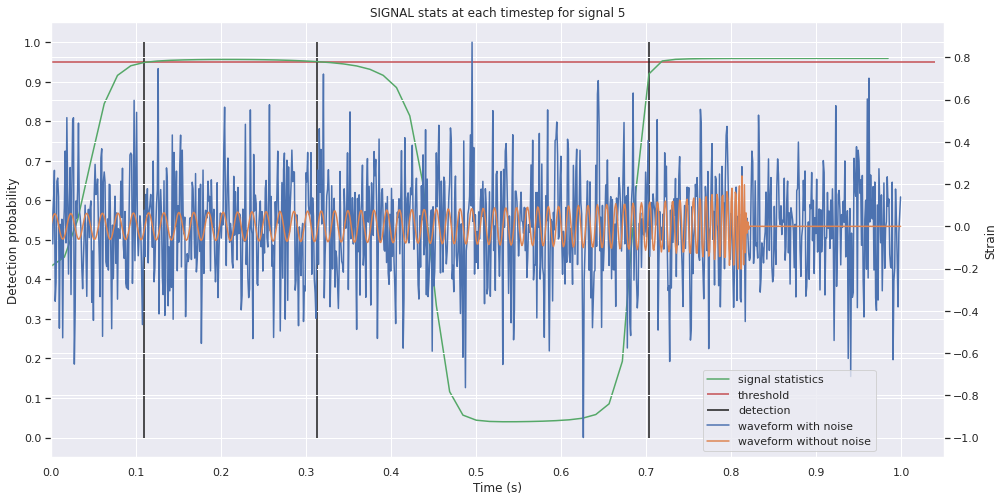

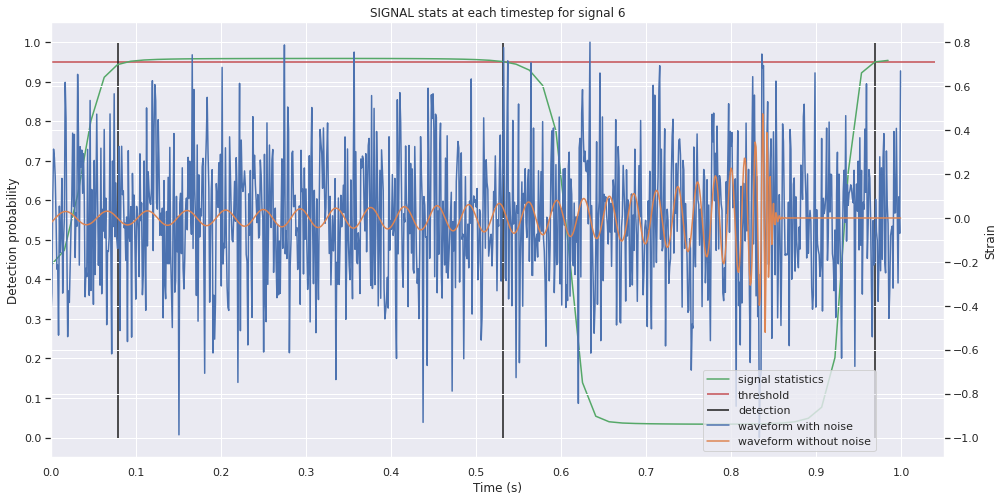

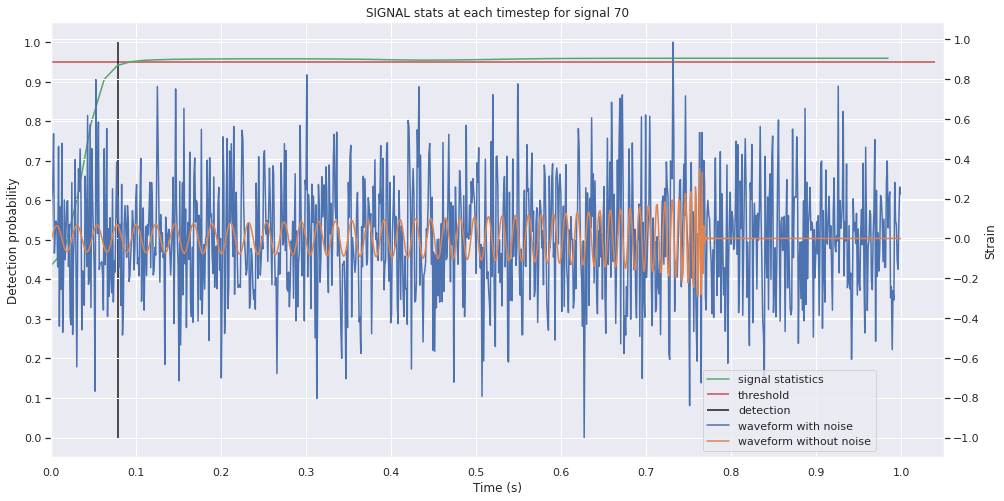

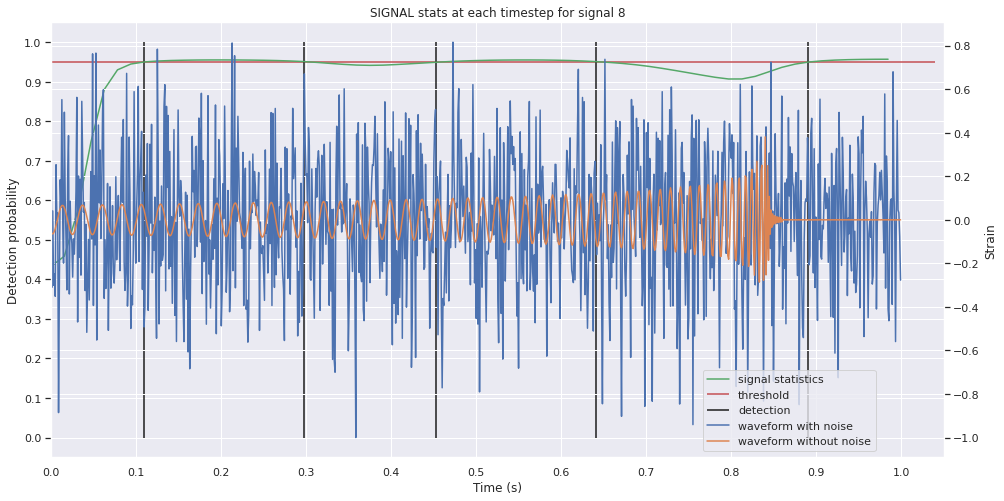

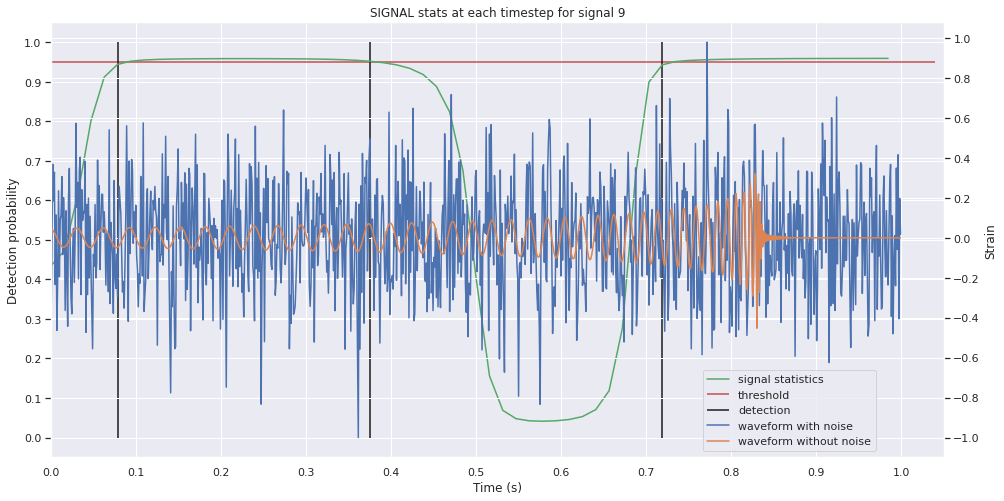

In [ ]:
# Plot 5 waveforms with signal + noise and the respective statistics with respect to time

threshold = 0.95
t = np.arange(0, duration, 1. / fs) # array of time steps = 1/fs
steps = np.arange(0,1,1/N_STEPS)

A = [0,1,2,3,100,5,6,70,8,9]

for a in A:

  fig, ax = plt.subplots(figsize=[16,8])
  plt.title(f'SIGNAL stats at each timestep for signal {a}')
  idx1 = np.argwhere(np.diff(np.sign(np.array(stat_s[a]) - threshold))).flatten()

  # statistics
  ax.set_xticks(np.arange(0,1.1,0.1))
  ax.plot(steps, stat_s[a], color='g', label='signal statistics')
  ax.set_xlabel(r"Time (s)")
  ax.set_ylabel("Detection probability")
  ax.set_xlim(0,1.05)
  ax.set_yticks(np.arange(0,1.1,0.1))
  ax.hlines(y = threshold, xmin=0, xmax=1.04, label = 'threshold', color = 'r')
  ax.vlines(x = ((idx1*N_INPUTS)/fs), ymin=0, ymax= 1, color='k', label = 'detection')

  # waveforms
  ax2 = ax.twinx()
  ax2.set_yticks(np.arange(-1,1.1,0.2))
  ax2.set_ylabel("Strain")
  ax2.plot(t, (signals[a]/(torch.max(np.abs(signals[a])))).view(-1,1024,1)[0,0:1024], label='waveform with noise')
  ax2.plot(t, (signals0[a]/(torch.max(np.abs(signals[a])))).view(-1,1024,1)[0,0:1024], label= 'waveform without noise')

  fig.legend(loc=(0.7,0.1))
  plt.show()

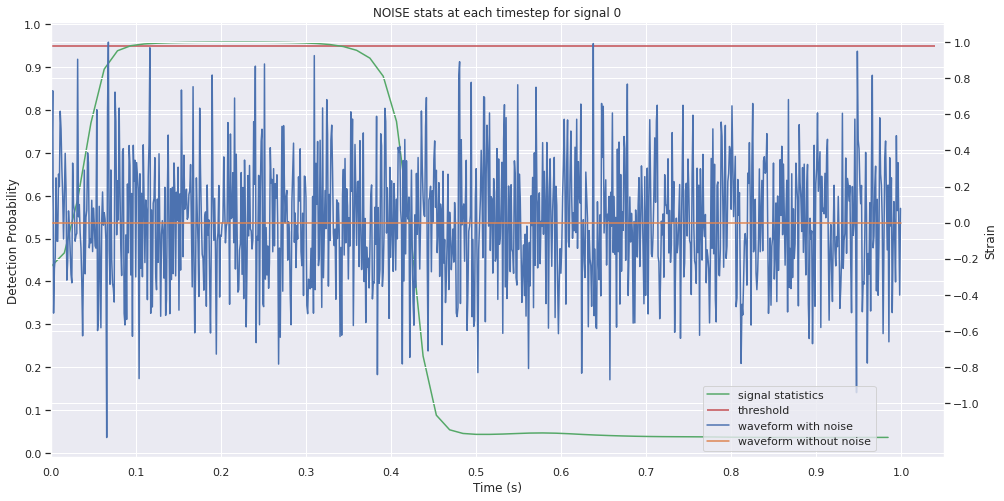

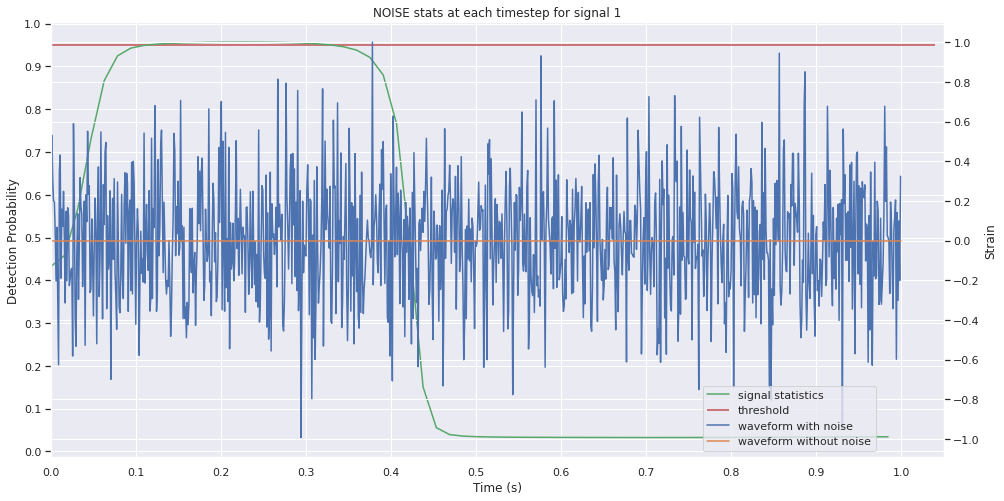

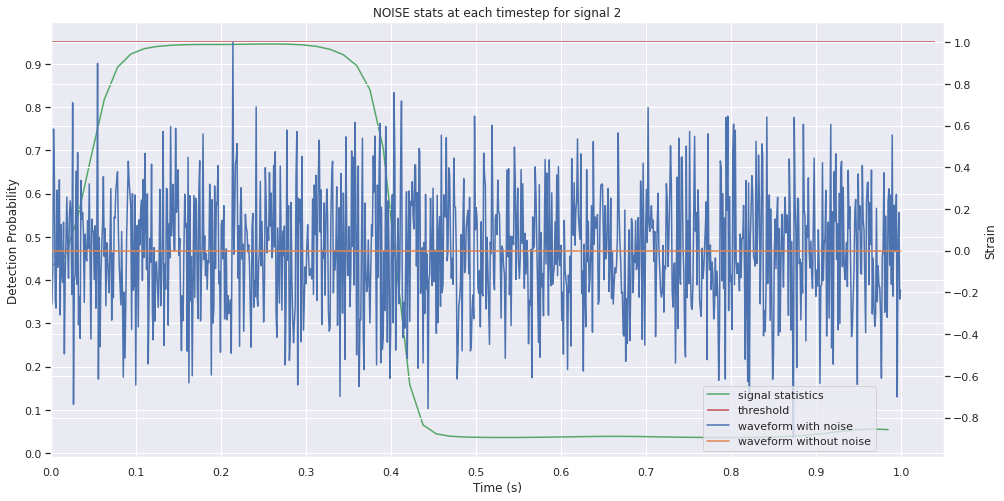

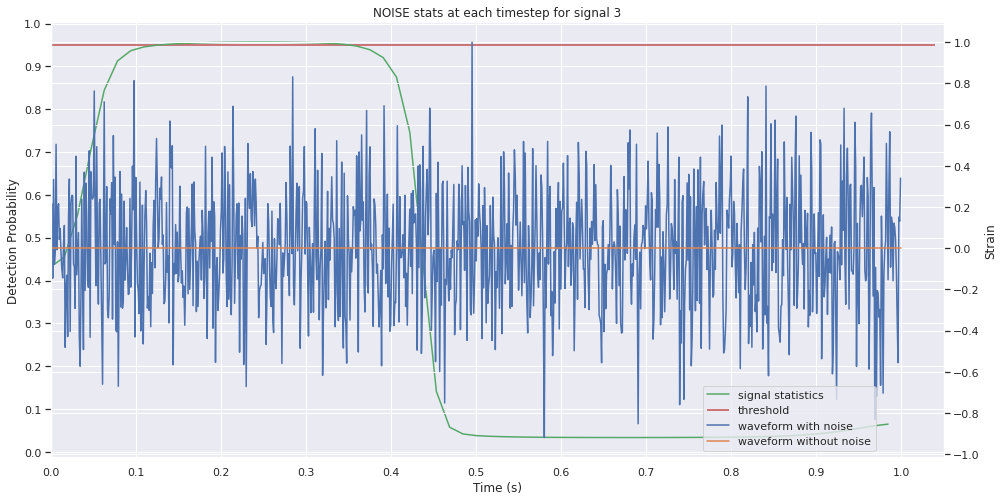

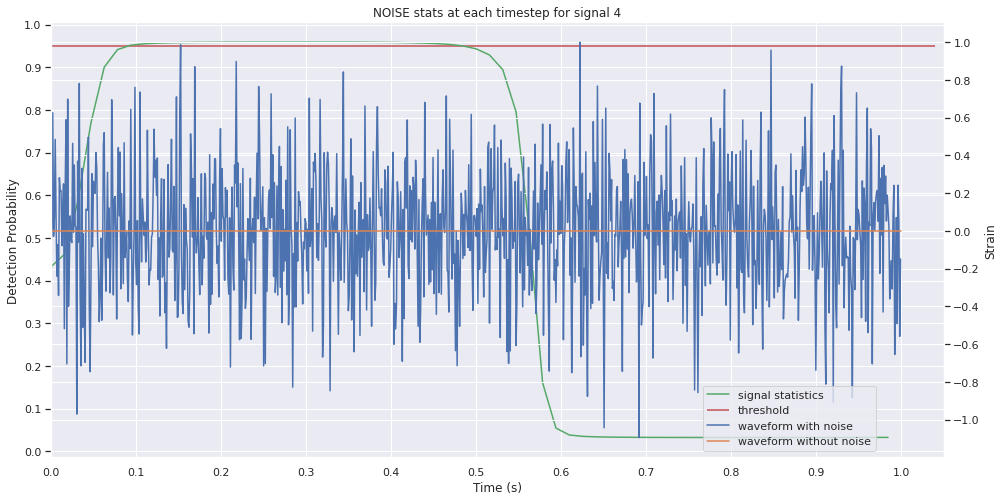

In [ ]:
# Plot 5 waveforms with only noise and the respective statistics with respect to time

B = [0,1,2,3,4]
threshold = 0.95

for b in B:

  fig, ax = plt.subplots(figsize=[16,8])
  plt.title(f'NOISE stats at each timestep for signal {b}')
  idx1 = np.argwhere(np.diff(np.sign(np.array(stat_n[b]) - threshold))).flatten()
  plt.grid

  # statistics
  ax.set_xticks(np.arange(0,1.1,0.1))
  ax.plot(steps, stat_n[b], color='g', label='signal statistics')
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Detection Probability")
  ax.set_xlim(0,1.05)
  ax.set_yticks(np.arange(0,1.1,0.1))
  ax.hlines(y = threshold, xmin=0, xmax=1.04, label = 'threshold', color = 'r')
  #ax.vlines(x = ((idx1*N_INPUTS)/fs), ymin=-1, ymax= 1, color='k', label = 'detection')

  # waveforms
  ax2 = ax.twinx()
  ax2.set_yticks(np.arange(-1,1.1,0.2))
  ax2.set_ylabel("Strain")
  ax2.plot(t, (noise[b]/(torch.max(noise[b]))).view(-1,1024,1)[0,0:1024], label='waveform with noise')
  ax2.plot(t, (noise0[b]).view(-1,1024,1)[0,0:1024], label= 'waveform without noise')

  fig.legend(loc=(0.7,0.1))
  plt.show()

# PERFORMANCE EVALUATION

With the following code I wanted to evaluate the diagnostic ability of the network. I did this by plotting a confusion matrix with a threshold for detection equal to 90% and a Receiver Operating Characteristic curve, which shows the goodness of the network as the detection threshold is varied.


The confusion matrix below was plotted using the true labels associated to the waveforms and the predictions of the network. A threshold of 0.9 was chosen: if the signal statistic fails to reach this threshold the waveform will be considered to be made up of just noise, even if probabilty of detection > 0.5. 


In [ ]:
# CONFUSION MATRIX

labels_t = np.array(labels_t)

predictions = []
for i in range(0,data_test.size(0)//BATCH_SIZE):
  out_t = P_s[i][-1]
  pred = []
  for j in range(0, BATCH_SIZE):
    out = out_t[j]
    if out < 0.9:   # the threshold is set to be 0.9
      pred.append(0)
    else:
      pred.append(1)
  predictions.append(pred)

predictions = np.array(predictions)

#print(len(predictions))
#print(len(labels_t))

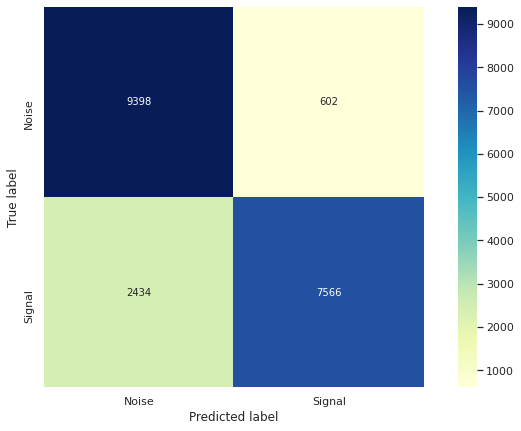

In [ ]:
cm = metrics.confusion_matrix(labels_t.flatten(), predictions.flatten())

fig = plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, square=True, fmt='g', cmap="YlGnBu",
            xticklabels=['Noise', 'Signal'], yticklabels=['Noise', 'Signal'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Reciever operator characteristic curves help determining how well the network performs. It's a plot of the true positive rate (probability of detection) against the false positive rate (probabilty of false alarm) as the detection threshold is changes.

outputs[-1].shape: torch.Size([100, 2]), outputs_roc.shape: (200, 100),  labels_test.shape: (200, 100)
thresholds: [1.95935994 0.95935994 0.95934033 ... 0.03245484 0.03245378 0.03226402]


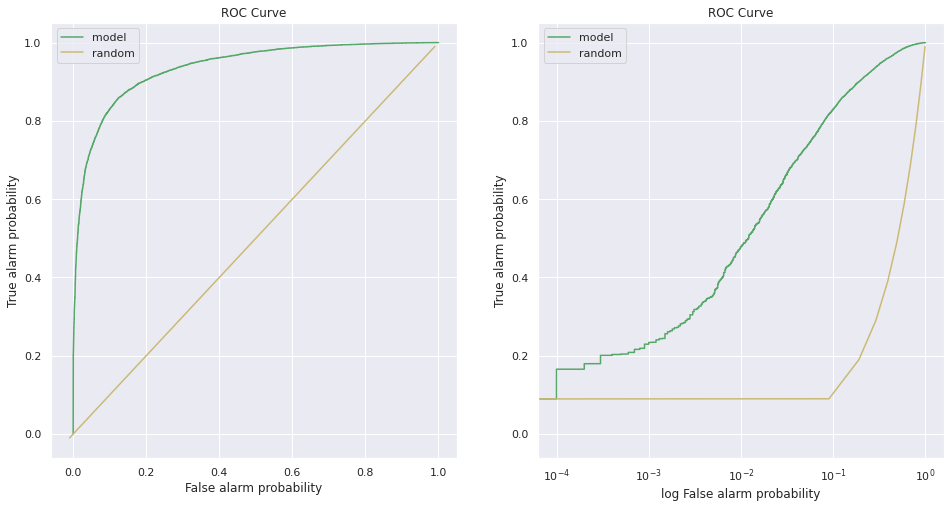

In [ ]:
outputs_roc = []
for i in range(0,data_test.size(0)//BATCH_SIZE):
  P_roc = P_s[i][-1]   # we want the signal output (hence we use P_s) for each of waveform at the last timestep
  outputs_roc.append(P_roc)

outputs_roc = np.array(outputs_roc)


print(f'outputs[-1].shape: {outputs[-1].shape}, outputs_roc.shape: {outputs_roc.shape},  labels_test.shape: {labels_t.shape}' )


P_false, P_true, threshold = metrics.roc_curve(labels_t.flatten(), outputs_roc.flatten())

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(P_false, P_true, color = 'g', label = 'model')
plt.plot(np.arange(-0.01,1.05,0.1),np.arange(-0.01,1.05,0.1),'y', label = 'random')
plt.xlabel('False alarm probability')
plt.ylabel('True alarm probability')
plt.title('ROC Curve')
plt.legend()
print(f'thresholds: {threshold}')

from matplotlib import pyplot
plt.subplot(1,2,2)

plt.plot(P_false, P_true, color = 'g', label = 'model')
plt.plot(np.arange(-0.01,1.05,0.1),np.arange(-0.01,1.05,0.1),'y', label = 'random')
pyplot.xscale('log')
plt.xlabel('log False alarm probability')
plt.ylabel('True alarm probability')
plt.title('ROC Curve')
plt.legend()
plt.show()

# CONCATENATING WAVEFORMS

A deep network used for gravitational waves detection should be able to analyse waveforms that are much longer than 1s. 
So, once the network gave satisfying results with 1 s long waveforms I tried to analyse of longer sequences of data, containing both a signal with noise and just noise. To do this, I concatenated 4 waveforms of just noise with a waveform of noise & signal, obtaining 5s long waveforms.  

Even though the network has been trained to anaylise 1s long waveforms, we can test it on longer waveforms by keeping the number of inputs the same but increasing the number of timesteps.

In [ ]:
# CREATE CONCATENATED WAVEFORM WITH 4 NOISE WAVEFORMS AND ONE SIGNAL + NOISE WAVEFORM

conc_signals = [] # for concatenated waveforms
conc_signals0 = [] # for concatenated waveforms with no noise

#print(inputs_test[0][0].shape)

for i in range(0,300):
  concatenated_waveform = torch.cat((noise[i].view(1,1024),noise[i+300].view(1,1024),signals[i].view(1,1024),noise[i+600].view(1,1024),noise[1+900].view(1,1024)), dim= 1)
  conc_signals.append(concatenated_waveform)
  concatenated_waveform0 = torch.cat((noise0[i].view(1,1024),noise0[i+300].view(1,1024),signals0[i].view(1,1024),noise0[i+600].view(1,1024),noise0[i+900].view(1,1024)), dim= 1)
  conc_signals0.append(concatenated_waveform0)
print(len(conc_signals), conc_signals[4].shape)

conc_s_test = torch.stack((conc_signals[0:300]),dim=0)  # concatenated waveforms for testing
conc_s_test0 = torch.stack((conc_signals0[0:300]),dim=0) # concatenated waveforms with no noise for testing

conc_s_test = conc_s_test.view(-1,5*N_STEPS,N_INPUTS)
conc_s_test0 = conc_s_test0.view(-1,5*N_STEPS,N_INPUTS)
print(conc_s_test.shape)

conc_labels1 = torch.ones(300,1) # labels for signal + noise
conc_labels0 = torch.zeros(300,1) # labels for just noise

# create tensor dataset for testing
concset_s = TensorDataset(conc_s_test, conc_labels1, conc_labels0, conc_s_test0)  
my_concloader_s = DataLoader(concset_s, batch_size= BATCH_SIZE, shuffle=False)

300 torch.Size([1, 5120])
torch.Size([300, 320, 16])


In [ ]:
conc_noise = []
conc_noise0 = []
for i in range(0,300):
  concatenated_noise = torch.cat((noise[i+1200].view(1,1024),noise[i+1500].view(1,1024),noise[i+1800].view(1,1024),noise[i+2100].view(1,1024),noise[1+2400].view(1,1024)), dim= 1)
  conc_noise.append(concatenated_noise)
  concatenated_noise0 = torch.cat((noise0[i+1200].view(1,1024),noise0[i+1500].view(1,1024),noise0[i+1800].view(1,1024),noise0[i+2100].view(1,1024),noise0[1+2400].view(1,1024)), dim= 1)
  conc_noise0.append(concatenated_noise0)

conc_n_test = torch.stack((conc_noise[0:300]),dim=0)
conc_n_test0 = torch.stack((conc_noise0[0:300]),dim=0)

conc_n_test = conc_n_test.view(-1,5*N_STEPS,N_INPUTS)
conc_n_test0 = conc_n_test0.view(-1,5*N_STEPS,N_INPUTS)

concset_n = TensorDataset(conc_n_test, conc_labels1, conc_labels0, conc_n_test0)
my_concloader_n = DataLoader(concset_n, batch_size= BATCH_SIZE, shuffle=False)

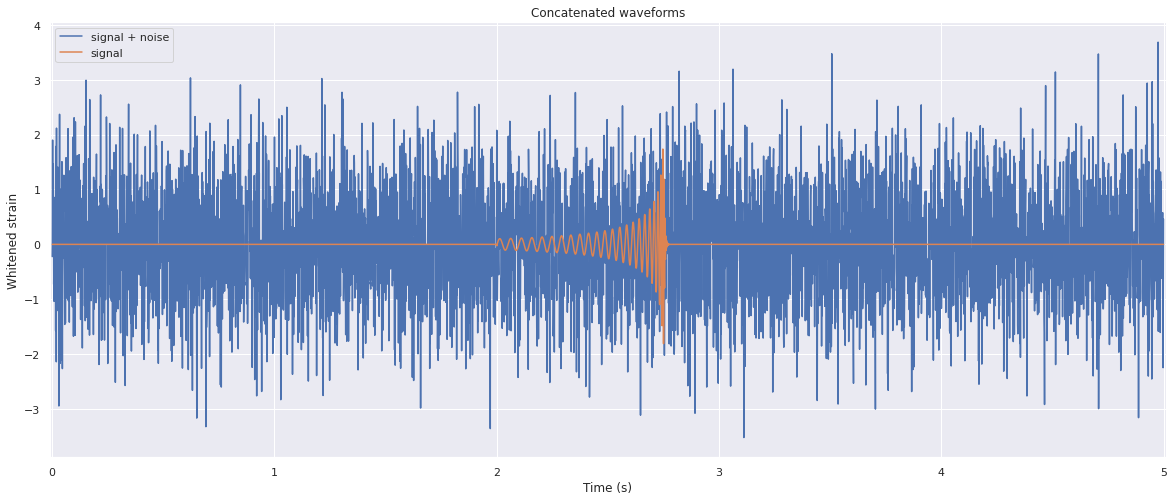

In [ ]:
# PLOT A CONCATENATED WAVEFORM

t_conc = np.arange(0, 5, 1. / fs)
plt.figure(figsize=[20,8])
plt.title('Concatenated waveforms')
plt.plot(t_conc, conc_signals[4].view(-1,1024*5,1)[0,0:1024*5], label = 'signal + noise')
plt.plot(t_conc, conc_signals0[7].view(-1,1024*5,1)[0,0:1024*5], label = 'signal')
plt.xlim(-0.01, 5.01)
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")

plt.legend()
plt.show()

Test on concatenated waveforms : we can calculate accuracy after each fifth of the waveform (1s) has gone through the network.

In [ ]:
test_acc_c1 = 0.0
test_acc_c2 = 0.0
test_acc_c3 = 0.0
test_acc_c4 = 0.0
test_acc_c5 = 0.0

# noise prob for all batches at all timesteps
P_s_c = []
S_inputs_test_conc = []
S_inputs0_test_conc = []

for i, data in enumerate(my_concloader_s,0):
    
    S_inputs_c, S_labels_c1, S_labels_c0, S_inputs0_c = data
    S_inputs_c = S_inputs_c.view(-1, N_STEPS*5, N_INPUTS).float()

    S_outputs_c = model(S_inputs_c)

    test_acc_c1 += get_accuracy(S_outputs_c[31], S_labels_c0, BATCH_SIZE)  
    test_acc_c2 += get_accuracy(S_outputs_c[63], S_labels_c0, BATCH_SIZE)
    test_acc_c3 += get_accuracy(S_outputs_c[95], S_labels_c1, BATCH_SIZE)
    test_acc_c4 += get_accuracy(S_outputs_c[127], S_labels_c0, BATCH_SIZE)
    test_acc_c5 += get_accuracy(S_outputs_c[159], S_labels_c0, BATCH_SIZE)

# noise prob for ith batch at all time steps
    p_s_c = []
    for j in range(0,N_STEPS*5):
  # noise prob for ith batch and jth time step
      ps_c = []
      for k in range(0, BATCH_SIZE):
        S_outputs_c[j] = S_outputs_c[j].detach()  # so that grad <backwards> isn't printed
        n_c = S_outputs_c[j][k][0].item() # gets noise probability
        s_c = S_outputs_c[j][k][1].item() # gets signal probability

        ps_c.append(s_c)   

      p_s_c.append(ps_c)

    P_s_c.append(p_s_c)
    S_inputs_test_conc.append(S_inputs_c)
    S_inputs0_test_conc.append(S_inputs0_c)

print('Test Accuracy1: %.2f, Test Accuracy2: %.2f, Test Accuracy3: %.2f, Test Accuracy4: %.2f, Test Accuracy5: %.2f' %(test_acc_c1/(conc_s_test.size(0)/BATCH_SIZE), test_acc_c2/(conc_s_test.size(0)/BATCH_SIZE), test_acc_c3/(conc_s_test.size(0)/BATCH_SIZE), test_acc_c4/(conc_s_test.size(0)/BATCH_SIZE), test_acc_c5/(conc_s_test.size(0)/BATCH_SIZE)))  #average test accuracy (num. correct guesses/number of batches)


Test Accuracy1: 43.67, Test Accuracy2: 90.33, Test Accuracy3: 8.33, Test Accuracy4: 90.33, Test Accuracy5: 76.33


320


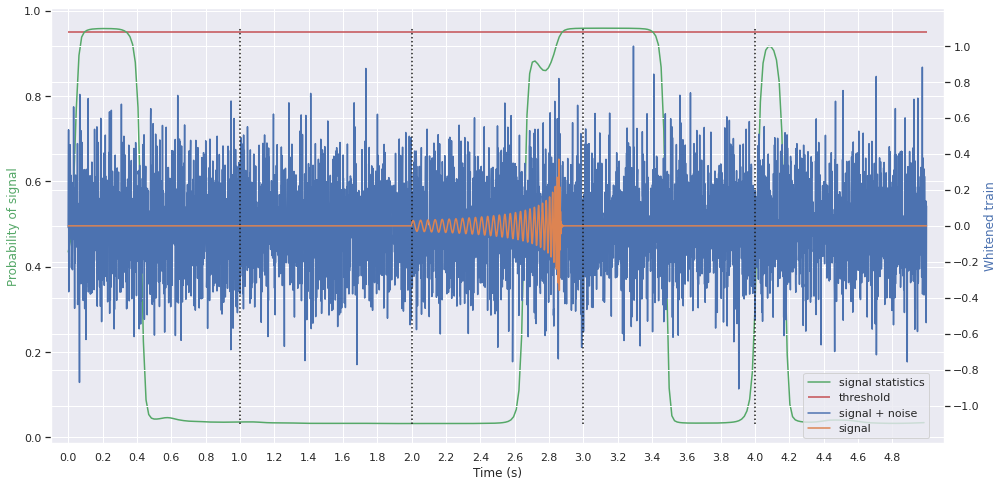

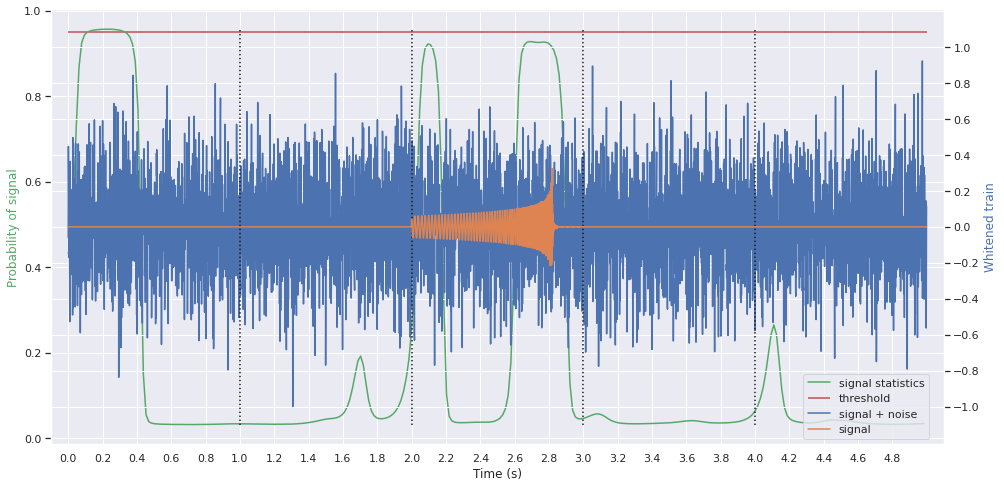

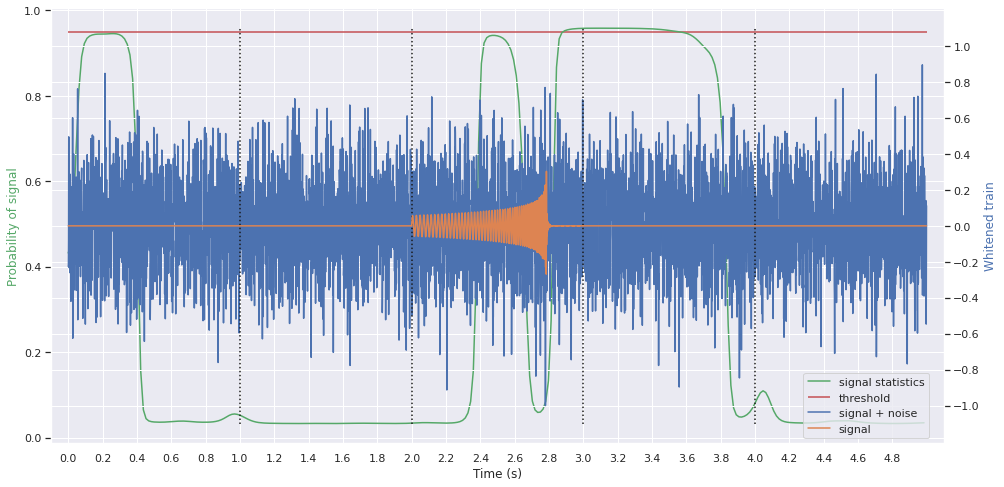

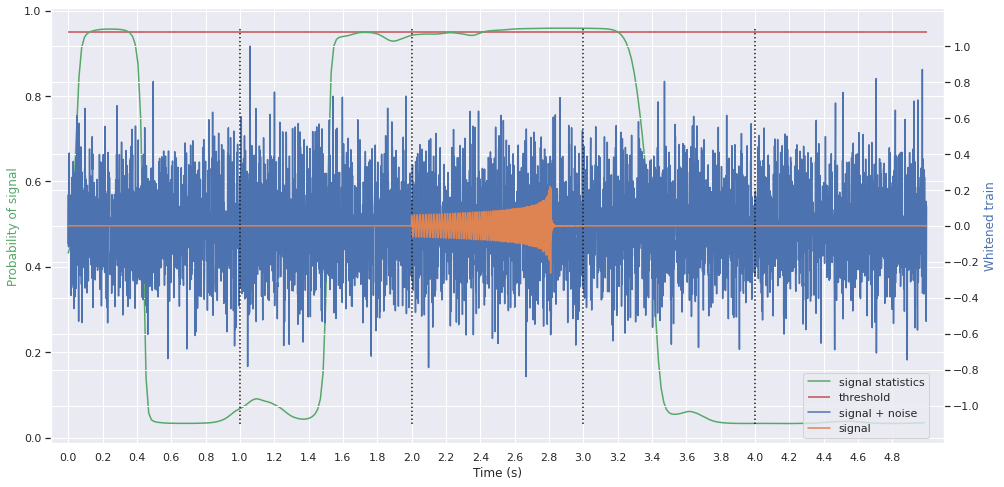

In [ ]:
# PLOT A FEW WAVEFORMS WITH THEIR CORRESPONDING DETECtION STATISTICS AGAINST TIME

steps_conc = np.arange(0,5,1/N_STEPS)
threshold = 0.95 

#print(len(P_s_c),len(P_s_c[0]),len(P_s_c[0][0]))
#print(len(S_inputs_test_conc),len(S_inputs_test_conc[0]),len(S_inputs_test_conc[0][0]))

batch = 0

Pc_s = []
for c in range(0,BATCH_SIZE):
  Prob_s = []
  for i in range(0, 5*N_STEPS):
    prob_s = P_s_c[batch][i][c]
    Prob_s.append(prob_s)
  Pc_s.append(Prob_s)
print(len(Prob_s))

# Prob_c has shape n_batches x n_timesteps x batch_size

for c in range(0, BATCH_SIZE):

  fig, ax = plt.subplots(figsize=[16,8])
  #plt.title('stats at each timestep for concatenated waveforms')


  

  # waveforms
  ax2 = ax.twinx()
  ax2.set_yticks(np.arange(-1,1.2,0.2))
  ax2.set_ylabel("Whitened train",color='b')
  ax2.plot(t_conc, (S_inputs_test_conc[batch][c]/torch.max(np.abs(S_inputs_test_conc[batch][c]))).view(-1,1024*5,1)[0,0:1024*5], label = 'signal + noise',zorder=1)
  ax2.plot(t_conc, (S_inputs0_test_conc[batch][c]/torch.max(np.abs(S_inputs_test_conc[batch][c]))).view(-1,1024*5,1)[0,0:1024*5], label = 'signal',zorder=2)
  idx = np.argwhere(np.diff(np.sign(np.array(Pc_s[c]) - threshold))).flatten()
  #plt.vlines(x = ((idx*N_INPUTS*5)/fs), ymin=-1, ymax= 1, color='k', label = 'detection')
  plt.vlines(x = 1, ymin=-1.1, ymax= 1.1, color = 'k',linestyles= 'dotted')
  plt.vlines(x = 2, ymin=-1.1, ymax= 1.1, color = 'k', linestyles= 'dotted')
  plt.vlines(x = 3, ymin=-1.1, ymax= 1.1, color = 'k', linestyles= 'dotted')
  plt.vlines(x = 4, ymin=-1.1, ymax= 1.1, color = 'k', linestyles= 'dotted')
  
  # statistics
  plt.xticks(np.arange(0,5,0.2))
  plt.xlim(-0.1,5.1)
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Probability of signal",color='g')
  ax.plot(steps_conc, Pc_s[c], label = 'signal statistics', color= 'g', zorder=8)
  ax.hlines(y = threshold, xmin=0, xmax=5, label = 'threshold', color = 'r')

  fig.legend(loc=(0.8,0.1))
  plt.show()

In [ ]:
test_acc_c1 = 0.0
test_acc_c2 = 0.0
test_acc_c3 = 0.0
test_acc_c4 = 0.0
test_acc_c5 = 0.0

# noise prob for all batches at all timesteps
P_n_c = []
#labels_t_conc = []  # labels for every waveform (10000 labels)
N_inputs_test_conc = []
N_inputs0_test_conc = []

for i, data in enumerate(my_concloader_n,0):
    
    N_inputs_c, N_labels_c1, N_labels_c0, N_inputs0_c = data
    N_inputs_c = N_inputs_c.view(-1, N_STEPS*5, N_INPUTS).float()

    N_outputs_c = model(N_inputs_c)
    print(len(N_outputs_c), N_outputs_c[0].shape)

    test_acc_c1 += get_accuracy(N_outputs_c[31], N_labels_c0, BATCH_SIZE)
    test_acc_c2 += get_accuracy(N_outputs_c[63], N_labels_c0, BATCH_SIZE)
    test_acc_c3 += get_accuracy(N_outputs_c[95], N_labels_c0, BATCH_SIZE)
    test_acc_c4 += get_accuracy(N_outputs_c[127], N_labels_c0, BATCH_SIZE)
    test_acc_c5 += get_accuracy(N_outputs_c[159], N_labels_c0, BATCH_SIZE)

# noise prob for ith batch at all time steps
    p_n_c = []
    for j in range(0,N_STEPS*5):
  # noise prob for ith batch and jth time step
      pn_c = []
      for k in range(0, BATCH_SIZE):
        N_outputs_c[j] = N_outputs_c[j].detach()  # so that grad <backwards> isn't printed
        n_c = N_outputs_c[j][k][0].item() # gets noise probability
        s_c = N_outputs_c[j][k][1].item() # gets signal probability

        pn_c.append(s_c)   

      p_n_c.append(pn_c)

    P_n_c.append(p_n_c)
    #labels_t_conc.append(labels_c.tolist()) 
    N_inputs_test_conc.append(N_inputs_c)
    N_inputs0_test_conc.append(N_inputs0_c)

  
print('Test Accuracy1: %.2f, Test Accuracy2: %.2f, Test Accuracy3: %.2f, Test Accuracy4: %.2f, Test Accuracy5: %.2f' %(test_acc_c1/(conc_n_test.size(0)/BATCH_SIZE), test_acc_c2/(conc_n_test.size(0)/BATCH_SIZE), test_acc_c3/(conc_n_test.size(0)/BATCH_SIZE), test_acc_c4/(conc_n_test.size(0)/BATCH_SIZE), test_acc_c5/(conc_n_test.size(0)/BATCH_SIZE)))  #average test accuracy (num. correct guesses/number of batches)

In [ ]:
steps_conc = np.arange(0,5,1/N_STEPS)
threshold = 0.95

print(len(P_s_c),len(P_s_c[0]),len(P_s_c[0][0]))
print(len(S_inputs_test_conc),len(S_inputs_test_conc[0]),len(S_inputs_test_conc[0][0]))
batch = 0

Pc_n = []
for c in range(0,BATCH_SIZE):
  Prob_n = []
  for i in range(0, 5*N_STEPS):
    prob_n = P_n_c[batch][i][c]
    Prob_n.append(prob_n)
  Pc_n.append(Prob_n)
print(len(Prob_n))

# Prob_c has shape n_batches x n_timesteps x batch_size

for c in range(0, BATCH_SIZE):

  fig, ax = plt.subplots(figsize=[16,8])
  #plt.title('stats at each timestep for concatenated waveforms')


  ax2 = ax.twinx()
  # waveforms
  ax2.set_yticks(np.arange(-1,1.2,0.2))
  ax2.set_ylabel("Whitened train",color='b')
  ax2.plot(t_conc, (N_inputs_test_conc[batch][c]/torch.max(N_inputs_test_conc[batch][c])).view(-1,1024*5,1)[0,0:1024*5], label = 'waveform with noise')
  ax2.plot(t_conc, (N_inputs0_test_conc[batch][c]).view(-1,1024*5,1)[0,0:1024*5], label = 'waveform without noise')
  idx = np.argwhere(np.diff(np.sign(np.array(Pc_s[c]) - threshold))).flatten()
  plt.vlines(x = 1, ymin=-1.1, ymax= 1.1, color = 'k',linestyles= 'dotted')
  plt.vlines(x = 2, ymin=-1.1, ymax= 1.1, color = 'k', linestyles= 'dotted')
  plt.vlines(x = 3, ymin=-1.1, ymax= 1.1, color = 'k', linestyles= 'dotted')
  plt.vlines(x = 4, ymin=-1.1, ymax= 1.1, color = 'k', linestyles= 'dotted')

  ax.legend()
  # statistics
  plt.xticks(np.arange(0,5,0.2))
  plt.xlim(-0.1,5.1)
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Probability of signal",color='g')
  ax.plot(steps_conc, Pc_n[c], color= 'g', label = 'signal statistics',zorder=8)
  ax.hlines(y = threshold, xmin=0, xmax=5, label = 'threshold', color = 'r')

  fig.legend(loc=(0.8,0.1))
  plt.show()
